# 在Fastai框架下基于BERT模型的中文文本分类


In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

## Preparation

In [2]:
#安装pytorch下包含BERT预训练模型的库
# !pip install pytorch-pretrained-bert

In [3]:
#引入必要的依赖包
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *

In [4]:
#设置一个config类，便于参数配置与更改
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

config = Config(
    testing=False,
    bert_model_name="bert-base-chinese", 
    #选用中文预训练模型：Chinese Simplified and Traditional, 12-layer, 768-hidden, 12-heads, 110M parameters
    max_lr=3e-5,
    epochs=5,
    use_fp16=False, #fastai里可以方便地调整精度，加快训练速度：learner.to_fp16()
    bs=8,
    max_seq_len=128, #选取合适的seq_length，较大的值可能导致训练极慢报错等
)

## Customize Tokenizer and Vocab

In [5]:
#pytorch_bert包提供了BertTokenizer类，从选取的模型中提取tok
from pytorch_pretrained_bert import BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
    config.bert_model_name,
)

定制Tokenizer需要继承fastai的BaseTokenizer类，注意BERT会在sequence的首尾加上特殊token[CLS]和[SEP]，与fastai里的bos和eos有重合，所以在之后会有include_eos=Fasle的设置

In [6]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around a BertTokenizer to be a BaseTokenizer in fastai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [7]:
#最终的tokenizer
fastai_tokenizer = Tokenizer(
    tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), 
    pre_rules=[], 
    post_rules=[]
)

In [8]:
#check the vocab
list(bert_tok.vocab.items())[1000:1010]

[('傲', 1000),
 ('傳', 1001),
 ('債', 1002),
 ('傷', 1003),
 ('傻', 1004),
 ('傾', 1005),
 ('僅', 1006),
 ('働', 1007),
 ('像', 1008),
 ('僑', 1009)]

In [9]:
#设置vocab
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

## Dataset

本次使用的数据集信息：

*   名称及出处：[ChnSentiCorp_htl_all](https://github.com/ZeroLeon/ChineseNlpCorpus/blob/master/datasets/ChnSentiCorp_htl_all/intro.ipynb)
*   数据概览： 7000 多条酒店评论数据，5000 多条正向评论，2000 多条负向评论
*   推荐实验： 情感/观点/评论 倾向性分析
*   数据来源： 携程网
*   原数据集： ChnSentiCorp_htl，由谭松波老师整理的一份数据集



In [10]:
# !wget https://github.com/SophonPlus/ChineseNlpCorpus/raw/master/datasets/ChnSentiCorp_htl_all/ChnSentiCorp_htl_all.csv

In [11]:
df_htl = pd.read_csv('data/ChnSentiCorp_htl_all.csv')

In [12]:
#标签涵义：1代表正向评论，0代表负向评论
label_denotation = {1:'positive',0:'negative'}
df_htl.sample(10)

,label,review
87,1,我已经住过两次了。比较满意，特别是接机服务，一个人也接，及时周到。宽带速度也比较快。但是没有...
4988,1,虽然遭遇台风“凤凰”，夜里没休息好，但极佳的位置，很好的服务总算弥补了一下。酒店旧了点，但时...
3027,1,"环境还不错滴~~就是入住时发生了一点小小的意外!预定是用英文名字预定的,登记的时候出示的是中..."
1523,1,服务还是不错。房间有些陈旧了，周边最近最近在建楼稍稍有些不太爽，不过关上窗户也没什么影响。所...
233,1,本次入住酒店的网络不是很稳定，断断续续，希望能够改进。
3800,1,由于酒店距火车站近，所以出租车不愿去，但这是长沙出租车主管部门的问题，和酒店无关，后来火车站...
5463,0,"给本酒店差评.遭遇如下:1.入住时被告知没有预订的'园林景观房',理由牵强,说是携程的订单不..."
3794,1,很不错呀，就是浴室太搞笑了，三个水龙头，也没标哪个热水哪个冷水。电梯太慢，其它都还好，早餐很...
771,1,"这家酒店真的不错.在这住了4天给了我3个惊喜:1.房间比我想像的要大,还有沙发.2.每天有水..."
5317,1,绝对是超三星标准，地处商业区，购物还是很方便的，对门有家羊杂店，绝对正宗。除了价格稍贵，总体...


- 正负向语料

In [13]:
print('评论数目（总体）：%d' % df_htl.shape[0])
print('评论数目（正向）：%d' % df_htl[df_htl.label==1].shape[0])
print('评论数目（负向）：%d' % df_htl[df_htl.label==0].shape[0])

评论数目（总体）：7766
评论数目（正向）：5322
评论数目（负向）：2444


In [14]:
df_htl.dropna(inplace=True)

### 构造平衡语料
- 用随机抽样的方法，很容易构造出类似的平衡语料

In [15]:
pd_positive = df_htl[df_htl.label==1]
pd_negative = df_htl[df_htl.label==0]

def get_balance_corpus(corpus_size, corpus_pos, corpus_neg):
    sample_size = corpus_size // 2
    # 是否有放回抽样
    pd_corpus_balance = pd.concat([corpus_pos.sample(sample_size, replace=corpus_pos.shape[0]<sample_size), \
                                   corpus_neg.sample(sample_size, replace=corpus_neg.shape[0]<sample_size)])
    
    print('评论数目（总体）：%d' % pd_corpus_balance.shape[0])
    print('评论数目（正向）：%d' % pd_corpus_balance[pd_corpus_balance.label==1].shape[0])
    print('评论数目（负向）：%d' % pd_corpus_balance[pd_corpus_balance.label==0].shape[0])    
    
    return pd_corpus_balance

In [16]:
ChnSentiCorp_htl_ba_10000 = get_balance_corpus(10000, pd_positive, pd_negative)
ChnSentiCorp_htl_ba_10000.sample(10)

评论数目（总体）：10000
评论数目（正向）：5000
评论数目（负向）：5000


,label,review
2270,1,酒店的服务人员服务周到，细致，给人一种宾至如归的感觉。
6245,0,本来想订的不是这家。找酒店时看到这家每条点评都有回馈，觉得服务不错，就订了。但是对于我们自驾...
7244,0,"携程推荐不怎么样,总台登记后房间在打扫,让在大堂等一下,但等了一小时也没人过问,经过与大堂副..."
5707,0,没有住过这么差的2星级酒店：白色的床灯灯罩霉到发黑。浴缸锈到有5块斑点，就像是这次在涠洲岛上...
6814,0,缺点：1.酒店靠近铁路，晚上睡觉非常吵2.酒店隔音效果非常差，邻居像和自己住在同一个房间3....
4,1,"CBD中心,周围没什么店铺,说5星有点勉强.不知道为什么卫生间没有电吹风"
6989,0,"俗话说""便宜没好货"",""一分价钱一分货"",建议携程网不要再向客户推荐该酒店."
3017,1,5.1期间入住的，我住的是小标间，去了才知道小标间是靠马路的几栋。由于修路车辆不是很多，所以...
7666,0,"交通还比较方便,价格相对便宜,但是设施有些陈旧,没有网络可上网,服务生的素质相对较低些,如果..."
6533,0,房间


In [17]:
#分割训练集train与验证集val
from sklearn.model_selection import train_test_split
# 按分类分层抽样
train, val = train_test_split(ChnSentiCorp_htl_ba_10000, test_size=0.1, stratify=ChnSentiCorp_htl_ba_10000.label)

In [18]:
#check their size
print(train.shape,val.shape)

(9000, 2) (1000, 2)


In [19]:
train[train.label==1].shape[0], train[train.label==0].shape[0]
val[val.label==1].shape[0], val[val.label==0].shape[0]

(4500, 4500)

(500, 500)

In [20]:
train.head()

,label,review
1430,1,在香港难得有那么大的房间，不过就是卫生间旧了一点。对于去香港血拼的人来说这是最好的选择，因为...
5243,1,地段好，到九龙坐酒店门口的天星小轮很方便，坐地铁沿着天桥走就到了，一点不用晒太阳，熟悉天桥，...
5887,0,电梯维修，只能爬楼，房间不大，设施一般。房间里居然连个大灯都没有，只有一盏远远的台灯晃着暗暗...
7106,0,"缺点是房间里一点信号都没.这点很恼火,试问一下万一家中有急事,却联系不到本人怎么办?问题很严..."
7293,0,住过很多大连酒店，这个酒店是最差的，客人在房间呆了一个小时不到的时间，酒店竟然收取了100元...


In [21]:
train.columns

Index(['label', 'review'], dtype='object')

In [22]:
train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)

In [23]:
val.head()

,label,review
0,1,周围环境有些乱，但是很热闹吃饭的地方也比较多。房间还可以。
1,0,地毯很赃床下的簧凸出睡得很不舒服隔音很差很吵市有段距不是很方便我得糟糕透了补充点评2007年...
2,0,还是一个多月前住的了.印象很深刻.酒店外表看起来是很不错.里面还算一般了.给我印象深刻的是我...
3,1,硬件设施，前台服务，房间服务都不错，值得表扬。早餐种类也还算丰富，6点半就有了，这点不错。宾...
4,0,"酒店设施烂的可以,说明了宽带上网,永远是上不去的,跟去年十月的时候一样,象如家这样的酒店,携..."


In [24]:
#建立TextDataBunch
databunch = TextClasDataBunch.from_df(".", train, val,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="review",
                  label_cols='label',
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0)
             )

In [25]:
doc(pad_collate)

pad_collate [source] [test] pad_collate ( samples : BatchSamples , pad_idx : int = 1 , pad_first : bool = True , backwards : bool = False ) → Tuple [ LongTensor , LongTensor ] 
 
 × No tests found for pad_collate . To contribute a test please refer to this guide and this discussion . Function that collect samples and adds padding. Flips token order if needed 
 Show in docs

In [26]:
databunch.show_batch()

text,target
[CLS] 我 想 在 此 提 供 本 人 的 入 住 经 历 给 大 家 ， 仅 供 参 考 1 . 提 前 预 订 酒 店 时 就 曾 打 电 话 申 明 过 需 要 接 机 ， 结 果 当 日 下 机 后 和 老 公 托 着 行 李 前 前 后 后 找 了 一 圈 也 没 找 到,0
[CLS] 我 是 1 月 20 日 入 住 的 。 。 订 的 大 床 房 。 位 于 西 环 的 中 远 ， 很 明 显 有 内 地 装 修 的 风 格 。 。 哈 哈 。 比 如 电 视 能 收 到 中 央 一 台 而 没 有 cnn 之 类 的 。 。 400 一 晚 。 。 后 来 两,1
[CLS] 去 过 中 茵 皇 冠 公 寓 ， 味 道 太 大 。 苏 州 索 菲 特 ， 大 堂 装 修 尚 可 ， 房 间 和 楼 道 太 简 单 。 只 有 尼 盛 万 丽 不 错 。 。 公 司 2 次 来 人 都 住 这 里 ， 非 常 不 错 。 服 务 很 好 ， 很 温,1
[CLS] 房 间 有 味 道 ， 服 务 实 在 不 敢 恭 维 ， 预 订 的 房 间 给 卖 掉 ， 好 在 给 免 费 升 级 ， 还 算 不 错 。 就 是 实 在 可 气 的 是 退 房 后 我 忘 在 酒 店 了 衣 服 ， 在 前 台 办 理 手 续 的 时 候 不 予,0
[CLS] 入 住 西 楼 海 景 套 房 （ 据 说 离 海 更 近 一 点 ） ， 应 该 说 总 体 很 不 错 ， 有 老 五 星 的 风 范 。 服 务 也 比 较 热 情 。 可 能 是 比 较 老 或 是 空 调 或 是 近 海 的 原 因 ， 房 间 内 稍 有 一 点,1


In [27]:
x, y = databunch.train_ds[0]

In [28]:
str(x)
y
y.data

'[CLS] 在 香 港 难 得 有 那 么 大 的 房 间 ， 不 过 就 是 卫 生 间 旧 了 一 点 。 对 于 去 香 港 血 拼 的 人 来 说 这 是 最 好 的 选 择 ， 因 为 酒 店 就 在 海 港 城 内 ， 偌 大 的 海 港 城 逛 一 星 期 估 计 也 难 以 逛 全 ， 逛 累 了 还 可 以 直 接 到 酒 店 歇 一 歇 [SEP]'

Category 1

1

In [29]:
len(str(x))

185

In [30]:
x1, y1 = databunch.train_ds[2]
x1
y1

Text [CLS] 电 梯 维 修 ， 只 能 爬 楼 ， 房 间 不 大 ， 设 施 一 般 。 房 间 里 居 然 连 个 大 灯 都 没 有 ， 只 有 一 盏 远 远 的 台 灯 晃 着 暗 暗 的 光 。 最 恐 怖 的 是 窗 户 外 面 就 是 走 廊 ， 隔 音 基 本 为 零 ， 只 要 有 人 走 路 说 话 ， 都 会 有 回 音 ， 特 响 。 清 晨 就 有 酒 店 人 员 穿 着 拖 鞋 嘻 嘻 哈 哈 的 走 过 ， 您 就 别 想 睡 了 。 [SEP]

Category 0

In [31]:
len(str(x1))

241

## Model and Loss Function

In [32]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification
bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels=2)

In [33]:
#二分类问题选用CrossEntrypyLoss作为损失函数
loss_func = nn.CrossEntropyLoss()

In [34]:
#建立Learner(数据,预训练模型,损失函数)
learner = Learner(databunch, bert_model, loss_func=loss_func, metrics=accuracy)

In [35]:
#尝试寻找合适的最大学习率，这里使用了BERT原论文推荐的学习率3e-5作为默认值
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-04


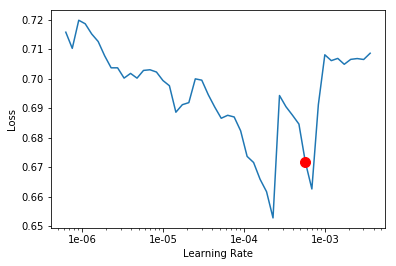

In [36]:
learner.recorder.plot(suggestion=True, skip_end=20)

In [37]:
#开始训练
learner.fit_one_cycle(config.epochs, slice(3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.286651,0.210489,0.908000,03:08
1,0.187557,0.171379,0.930000,03:09
2,0.127004,0.140221,0.950000,03:09
3,0.038747,0.172435,0.952000,03:09
4,0.008313,0.159150,0.959000,03:09


In [38]:
learner.save('htl_stage1')

In [39]:
learner.model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediat

In [40]:
learner.summary()

Layer (type)         Output Shape         Param #    Trainable 
Embedding            [128, 768]           16,226,304 True      
______________________________________________________________________
Embedding            [128, 768]           393,216    True      
______________________________________________________________________
Embedding            [128, 768]           1,536      True      
______________________________________________________________________
BertLayerNorm        [128, 768]           1,536      True      
______________________________________________________________________
Dropout              [128, 768]           0          False     
______________________________________________________________________
Linear               [128, 768]           590,592    True      
______________________________________________________________________
Linear               [128, 768]           590,592    True      
______________________________________________________________

In [41]:
learner.unfreeze()

In [42]:
learner.fit_one_cycle(3, slice(3e-5/2.6))

epoch,train_loss,valid_loss,accuracy,time
0,0.034001,0.352218,0.929000,03:09
1,0.014278,0.243409,0.950000,03:09
2,0.001612,0.281989,0.947000,03:09


In [43]:
learner.save('htl_stage2')

In [44]:
#用样例测试下
learner.predict("设施老化，紧靠马路噪音太大，晚上楼上卫生间的水流声和空调噪音非常大，无法入眠")

(Category 0, tensor(0), tensor([9.9972e-01, 2.8313e-04]))

In [45]:
learner.predict("位置真是好的没话讲，距解放碑步行只要两分钟不到，周边吃的、买的、看的都很多")

(Category 1, tensor(1), tensor([3.6966e-05, 9.9996e-01]))